# 1. Analyse Exploratoire et Préparation des Données - Chicago Taxi Trips

Ce notebook combine l'analyse exploratoire du dataset Chicago Taxi Trips et la préparation des données pour le forecasting. Nous allons :
- Explorer la structure et la qualité des données
- Analyser les distributions et tendances temporelles
- Préparer les données agrégées pour le forecasting par heure et par zone
- Enrichir le dataset avec des features temporelles
- Exporter les données vers BigQuery pour l'utilisation avec Vertex AI Forecast

## Table des Matières
1. [Configuration et Imports](#1.1-Configuration-et-Imports)
2. [Configuration du Projet](#1.2-Configuration-du-Projet)
3. [Analyse Exploratoire des Données](#2.-Analyse-Exploratoire-des-Données)
   - [Chargement d'un Échantillon](#2.1-Chargement-d'un-Échantillon-pour-Exploration)
   - [Comprendre les Données](#2.2-Comprendre-les-Données)
   - [Valeurs Manquantes](#2.3-Analyse-des-Valeurs-Manquantes)
   - [Tendances Temporelles](#2.4-Analyse-des-Tendances-Temporelles)
   - [Analyse Spatiale](#2.5-Analyse-Spatiale)
   - [Investigation des Outliers](#2.6-Investigation-des-Outliers)
4. [Préparation des Données pour le Forecasting](#3.-Préparation-des-Données-pour-le-Forecasting)
   - [Extraction des Données Complètes](#3.1-Extraction-des-Données-Complètes-pour-le-Forecasting)
   - [Agrégation Temporelle](#3.2-Agrégation-Temporelle-par-Heure-et-Zone)
   - [Complétion des Séries Temporelles](#3.3-Complétion-des-Séries-Temporelles)
   - [Ingénierie de Features](#3.4-Ingénierie-de-Features-Temporelles)
   - [Visualisation des Séries Temporelles](#3.5-Visualisation-des-Séries-Temporelles)
   - [Export vers BigQuery](#3.6-Export-vers-BigQuery-pour-Vertex-AI-Forecast)
5. [Conclusion et Prochaines Étapes](#4.-Conclusion-et-Prochaines-Étapes)

## 1.1 Configuration et Imports

Importons les bibliothèques nécessaires et initialisons la connexion à BigQuery.

In [1]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # pour visualiser les valeurs manquantes
import yaml # pour lire les fichiers de configuration
import os
from datetime import datetime, timedelta
from google.cloud import bigquery
import db_dtypes  # Pour les types de données spécifiques à BigQuery
from IPython.display import display

# Pour BigQuery
from pandas_gbq import read_gbq

# Configuration visuelle
%matplotlib inline
sns.set(style="whitegrid", context="talk")  # style épuré et taille adaptée aux présentations
base_palette = sns.color_palette("viridis", 8)
sns.set_palette(base_palette)

# Supprimer les warnings pour une sortie plus propre
import warnings
warnings.filterwarnings('ignore')

## 1.2 Configuration du Projet

Définissons les identifiants du projet GCP et les paramètres généraux.

In [2]:
# Configuration du projet GCP
# Load from YAML first
try:
    with open("../config/pipeline_config.yaml", "r") as f:
        config = yaml.safe_load(f)
    print("Configuration chargée avec succès depuis pipeline_config.yaml")
    PROJECT_ID = config.get('gcp', {}).get('project_id', 'avisia-certification-ml-yde') # Example structure
    REGION = config.get('gcp', {}).get('region', 'europe-west1')
    BQ_DATASET = config.get('bigquery', {}).get('dataset', 'chicago_taxis')
    # Add defaults if keys might be missing
except Exception as e:
    print(f"Impossible de charger le fichier de configuration: {e}. Using default values.")
    config = {}
    PROJECT_ID = "avisia-certification-ml-yde" # Fallback
    REGION = "europe-west1" # Fallback
    BQ_DATASET = "chicago_taxis" # Fallback

print(f"Using PROJECT_ID: {PROJECT_ID}, REGION: {REGION}, BQ_DATASET: {BQ_DATASET}")

# Initialisation du client BigQuery
client = bigquery.Client(project=PROJECT_ID)

Configuration chargée avec succès depuis pipeline_config.yaml
Using PROJECT_ID: avisia-certification-ml-yde, REGION: europe-west1, BQ_DATASET: chicago_taxis


# 2. Analyse Exploratoire des Données

Explorons le dataset Chicago Taxi Trips pour comprendre sa structure et identifier les patterns.

## 2.1 Chargement d'un Échantillon pour Exploration

Commençons par charger un échantillon limité pour l'exploration initiale.
Nous utiliserons les 100 000 voyages de la première semaine de Janvier 2023. Cela nous fournit un aperçu récent couvrant les tendances typiques pour la semaine et le weekend avec un échantillon d'une taille gérable pour une analyse interactive.

In [3]:
# Définition de la requête SQL pour récupérer un échantillon depuis BigQuery
sample_query = """
SELECT *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_start_timestamp BETWEEN '2023-01-01' AND '2023-01-07'
LIMIT 100000
"""

# Chargement du dataset depuis BigQuery
try:
    df_sample = pd.read_gbq(sample_query, project_id=PROJECT_ID)
    print("Dataset d'échantillon chargé avec succès depuis BigQuery.")
    print(f"✅ {len(df_sample)} lignes chargées.")

except Exception as e:
    print(f"Erreur lors du chargement depuis BigQuery: {e}")
    exit()

# Nettoyage initial des noms de colonnes
df_sample.columns = df_sample.columns.str.strip().str.lower().str.replace(' ', '_')
print("\nNoms des colonnes après nettoyage :")
print(df_sample.columns)

# Aperçu des données
print("\nAperçu des données (5 premières lignes) :")
df_sample.head()

Dataset d'échantillon chargé avec succès depuis BigQuery.
✅ 73747 lignes chargées.

Noms des colonnes après nettoyage :
Index(['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location'],
      dtype='object')

Aperçu des données (5 premières lignes) :


,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,0fca59218b11688279d795c03c4d16f851f13fa0,e2c349c7cbb608d552aa0b5814031943f13641ef9e50d8...,2023-01-01 00:00:00+00:00,2023-01-01 00:15:00+00:00,1037,4.82,<NA>,<NA>,6,32,...,0.0,19.50,Credit Card,Taxicab Insurance Agency Llc,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
1,45b2ea39cfff64d61a46ef016e16f8ee74e9ed23,a688de71e9eb70603ba839dc7faf949968ae3e971e0575...,2023-01-01 00:00:00+00:00,2023-01-01 00:00:00+00:00,361,0.63,<NA>,<NA>,32,32,...,1.0,6.50,Cash,5 Star Taxi,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
2,2b3c5200439d51f626b60380809bbbcca766a85b,8c76eb82f069c0731a0049cb78898f02cc5ac6990244c9...,2023-01-01 00:00:00+00:00,2023-01-01 00:15:00+00:00,844,3.84,<NA>,<NA>,24,8,...,0.0,20.17,Mobile,Sun Taxi,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,464df6aaaf97ca8745985c2a5b2e481067a2bfb6,8b1a88e5a09cfd55ca72d267f00f56fa50a42aa322bdfe...,2023-01-01 00:00:00+00:00,2023-01-01 00:15:00+00:00,704,0.99,<NA>,<NA>,14,14,...,0.0,7.75,Cash,Flash Cab,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
4,1e539d6e7501164c6b76b761c3152c235e206d59,4ab7a7510c1ebcc9b2e3eaa7bdd6508dbea34da7986aca...,2023-01-01 00:00:00+00:00,2023-01-01 00:15:00+00:00,1341,16.63,<NA>,<NA>,76,8,...,6.0,53.00,Credit Card,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)


## 2.2 Comprendre les Données

Analysons la structure et les statistiques descriptives des données.

In [4]:
import numpy as np # Make sure numpy is imported

# --- Conversion des types de données ---
print("Converting data types...")
# Timestamps
for col in ['trip_start_timestamp', 'trip_end_timestamp']:
    if col in df_sample.columns:
        df_sample[col] = pd.to_datetime(df_sample[col], errors='coerce')

# Numériques clés
cols_numeric = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total']
# Keep track of original NaN counts before coercion
nan_before = df_sample[cols_numeric].isnull().sum()
for col in cols_numeric:
    if col in df_sample.columns:
        df_sample[col] = pd.to_numeric(df_sample[col], errors='coerce')
# Calculate NaNs introduced by coercion
nan_after = df_sample[cols_numeric].isnull().sum()
nan_coerced = (nan_after - nan_before).sum()

print(f"Total NaNs coerced in numeric cols: {nan_coerced}")
# Directly calculate total NaNs present now
print(f"Total current NaNs in numeric cols: {df_sample[cols_numeric].isnull().sum().sum()}")
print(f"Total NaTs in datetime cols: {df_sample[['trip_start_timestamp', 'trip_end_timestamp']].isnull().sum().sum()}")

# --- Création de colonnes dérivées ---

# 1. Calculate Trip Minutes
if 'trip_seconds' in df_sample.columns:
    df_sample['trip_minutes'] = df_sample['trip_seconds'] / 60
    print("\n✅ Colonne 'trip_minutes' créée.")
else:
    print("\n⚠️ Colonne 'trip_seconds' manquante, impossible de créer 'trip_minutes'.")
    df_sample['trip_minutes'] = np.nan # Create column as NaN if source is missing

# 2. Calculate Average Speed (Vectorized & Robust)
if 'trip_miles' in df_sample.columns and 'trip_minutes' in df_sample.columns:
    print("\n🚕 Calcul de la vitesse moyenne en mph (vectorized)...")
    # Initialize the column with NaN
    df_sample['average_speed_mph'] = np.nan
    # Create a mask for valid calculations:
    # - trip_minutes must be greater than 0
    # - trip_minutes must not be NaN
    # - trip_miles must not be NaN
    mask = (df_sample['trip_minutes'] > 0) & df_sample['trip_minutes'].notna() & df_sample['trip_miles'].notna()
    # Perform calculation only where the mask is True
    df_sample.loc[mask, 'average_speed_mph'] = df_sample.loc[mask, 'trip_miles'] / (df_sample.loc[mask, 'trip_minutes'] / 60)
    print("✅ Colonne 'average_speed_mph' ajoutée/mise à jour.")
    # You can uncomment this to see basic stats immediately
    # print(df_sample['average_speed_mph'].describe())
else:
    print("\n⚠️ Colonnes 'trip_miles' ou 'trip_minutes' manquantes, impossible de calculer la vitesse moyenne.")
    if 'average_speed_mph' not in df_sample.columns:
         df_sample['average_speed_mph'] = np.nan # Ensure column exists

# --- Afficher les informations et statistiques ---
print("\nInformations générales sur le DataFrame:")
# Limit info output if dataframe is very wide
df_sample.info(verbose=True, show_counts=True)

print("\nStatistiques descriptives:")
# Use display for better formatting in notebooks
from IPython.display import display
display(df_sample.describe(include='all').T)

Converting data types...
Total NaNs coerced in numeric cols: 0
Total current NaNs in numeric cols: 393
Total NaTs in datetime cols: 8

✅ Colonne 'trip_minutes' créée.

🚕 Calcul de la vitesse moyenne en mph (vectorized)...
✅ Colonne 'average_speed_mph' ajoutée/mise à jour.

Informations générales sur le DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73747 entries, 0 to 73746
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              73747 non-null  object             
 1   taxi_id                 73747 non-null  object             
 2   trip_start_timestamp    73747 non-null  datetime64[us, UTC]
 3   trip_end_timestamp      73739 non-null  datetime64[us, UTC]
 4   trip_seconds            73719 non-null  Int64              
 5   trip_miles              73747 non-null  float64            
 6   pickup_census_tract     20491 non-null  Int64      

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
unique_key,73747,73747,93f61e9c31c96bc5376ceb336adcbaa1159cd721,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taxi_id,73747,2100,2780ead18beaa862cc67315ddabd9d1acaadcd6da82eba...,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trip_start_timestamp,73747,NaN,NaN,NaN,2023-01-04 05:41:26.261136+00:00,2023-01-01 00:00:00+00:00,2023-01-02 19:00:00+00:00,2023-01-04 10:00:00+00:00,2023-01-05 16:15:00+00:00,2023-01-07 00:00:00+00:00,NaN
trip_end_timestamp,73739,NaN,NaN,NaN,2023-01-04 06:00:24.691140+00:00,2023-01-01 00:00:00+00:00,2023-01-02 19:15:00+00:00,2023-01-04 10:15:00+00:00,2023-01-05 16:30:00+00:00,2023-01-23 08:45:00+00:00,NaN
trip_seconds,73719.0,<NA>,<NA>,<NA>,1087.195838,0.0,439.0,857.0,1499.0,80066.0,1740.331938
trip_miles,73747.0,NaN,NaN,NaN,6.587517,0.0,0.9,3.07,11.36,899.5,10.818466
pickup_census_tract,20491.0,<NA>,<NA>,<NA>,17031474653.340149,17031010202.0,17031081500.0,17031320100.0,17031839100.0,17031980100.0,370025.908828
dropoff_census_tract,20139.0,<NA>,<NA>,<NA>,17031386842.802523,17031010201.0,17031081403.0,17031281900.0,17031838100.0,17031980100.0,334971.920936
pickup_community_area,69041.0,<NA>,<NA>,<NA>,34.441752,1.0,8.0,32.0,56.0,77.0,26.225805
dropoff_community_area,66006.0,<NA>,<NA>,<NA>,24.936354,1.0,8.0,24.0,32.0,77.0,20.547129


## 2.3 Analyse des Valeurs Manquantes

Visualisons et quantifions les valeurs manquantes dans le dataset.


Pourcentage de valeurs manquantes par colonne (> 0%):
dropoff_census_tract      72.691771
pickup_census_tract       72.214463
dropoff_community_area    10.496698
dropoff_location          10.205161
dropoff_latitude          10.205161
dropoff_longitude         10.205161
pickup_community_area      6.381277
pickup_longitude           6.370429
pickup_location            6.370429
pickup_latitude            6.370429
average_speed_mph          1.963470
fare                       0.098987
extras                     0.098987
trip_total                 0.098987
tips                       0.098987
tolls                      0.098987
trip_seconds               0.037968
trip_minutes               0.037968
trip_end_timestamp         0.010848
dtype: float64


<Figure size 1600x800 with 0 Axes>

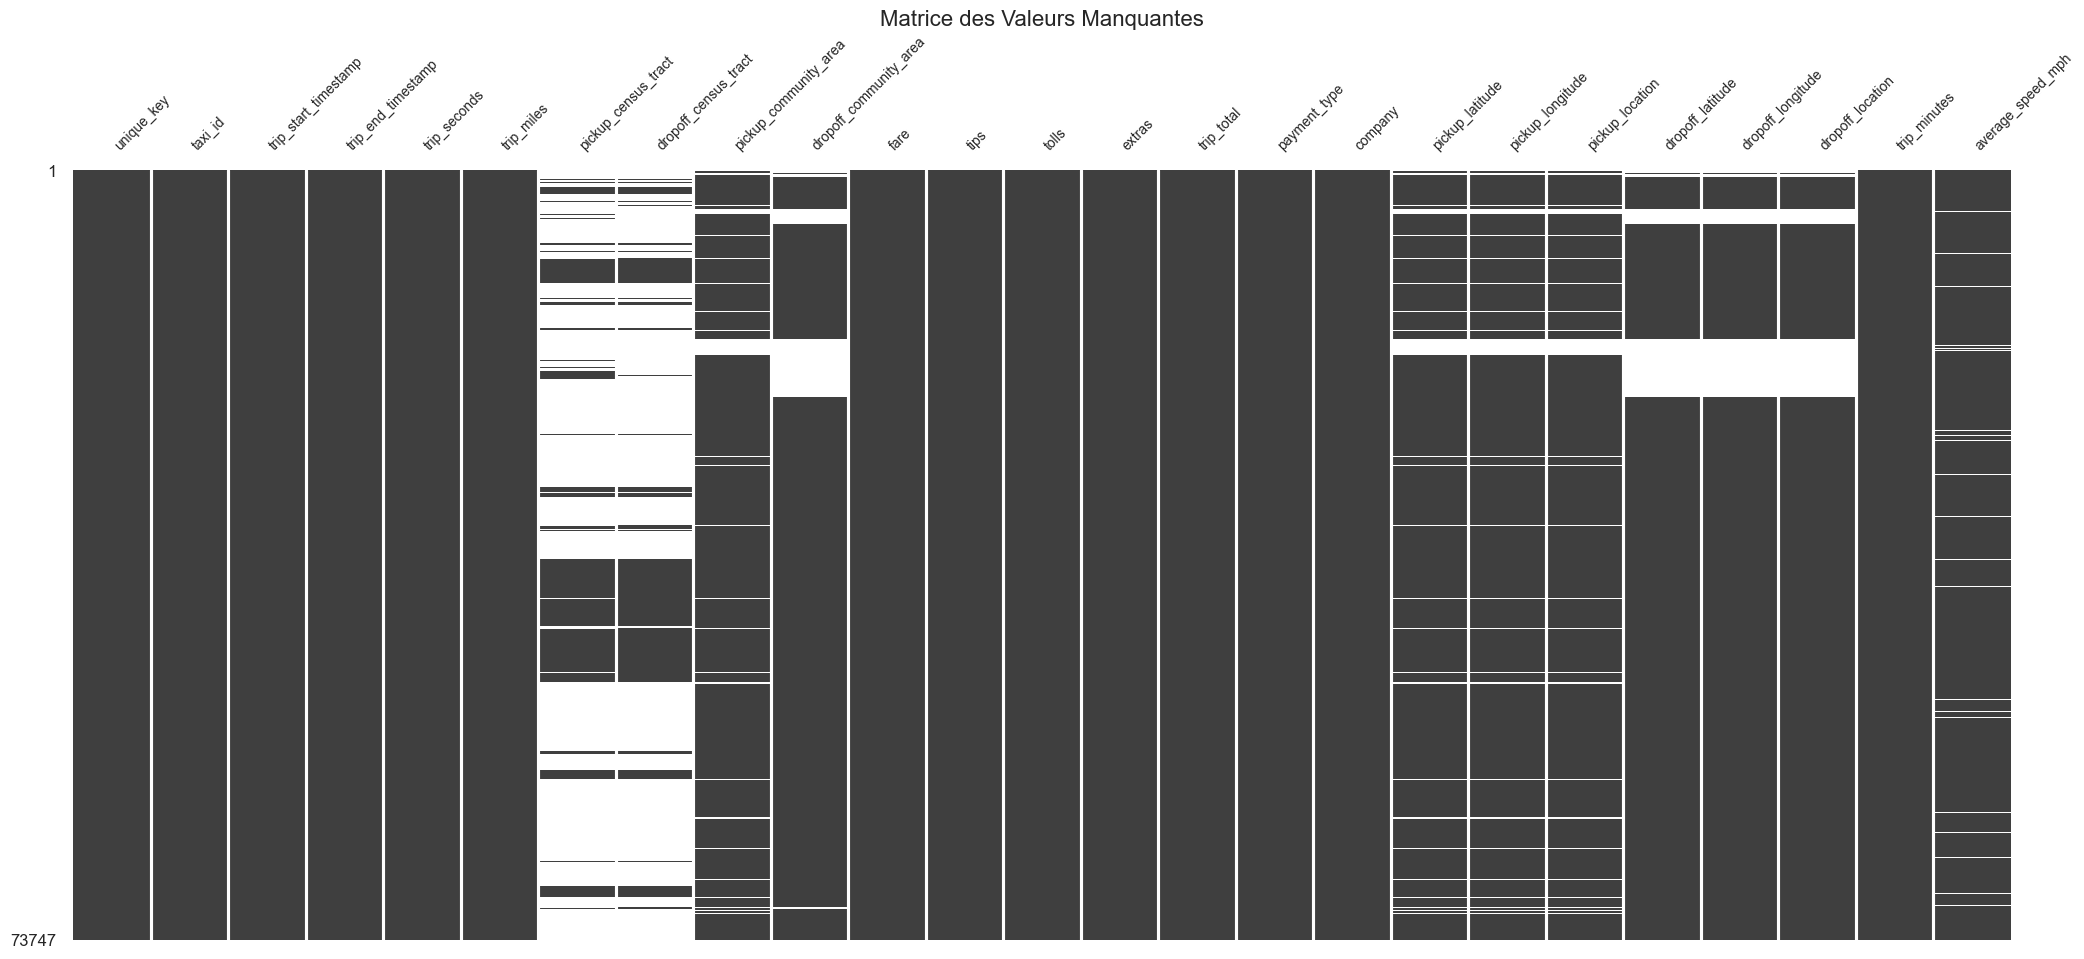

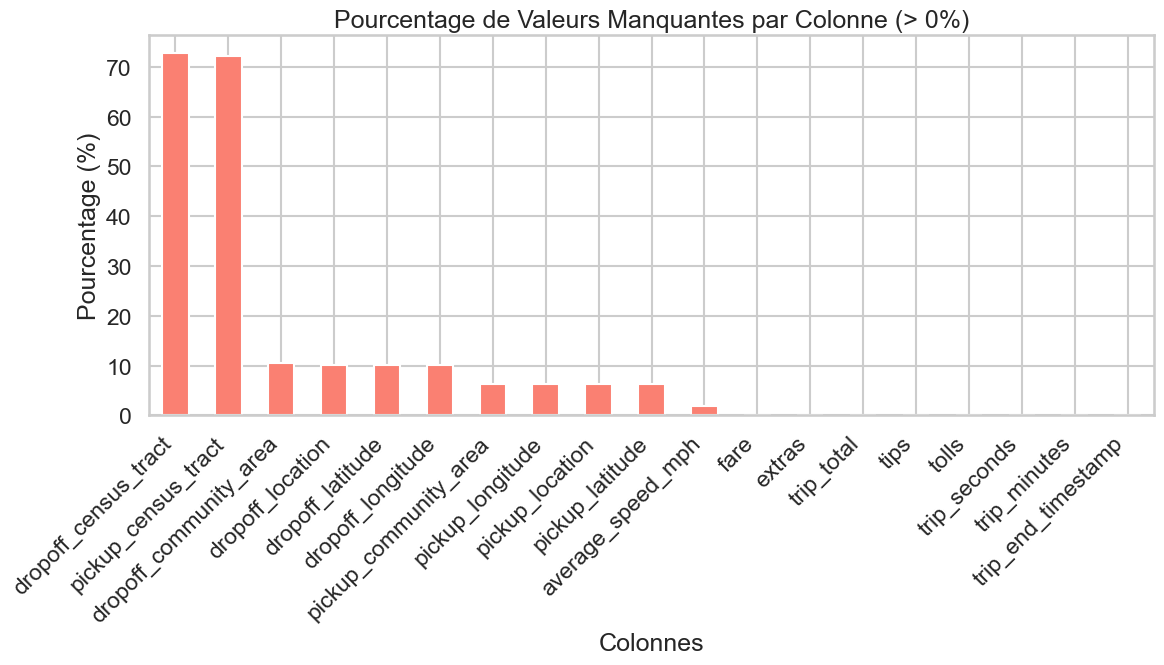

In [5]:
# Calcul et tri des pourcentages de valeurs manquantes
missing_pct = df_sample.isnull().sum() / len(df_sample) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
print("\nPourcentage de valeurs manquantes par colonne (> 0%):")
print(missing_pct)

# Visualisation du pattern des valeurs manquantes
plt.figure(figsize=(16, 8))
msno.matrix(df_sample.iloc[:, :40], sparkline=False, fontsize=10)
plt.title("Matrice des Valeurs Manquantes", fontsize=16)
plt.show()

# Visualisation par barre
if len(missing_pct) > 0:
    plt.figure(figsize=(12, 7))
    missing_pct.plot(kind='bar', color='salmon')
    plt.title("Pourcentage de Valeurs Manquantes par Colonne (> 0%)")
    plt.ylabel("Pourcentage (%)")
    plt.xlabel("Colonnes")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

La matrice de valeurs manquantes confirme visuellement les pourcentages calculés ci-dessus. Il ne semble pas y avoir de forte corrélation entre les valeurs manquantes dans différentes colonnes au sein de cet échantillon, à l'exception peut-être des coordonnées géographiques. Pour la tâche de forecasting, nous nous concentrerons sur trip_start_timestamp et pickup_community_area. La requête BigQuery dans la Section 3 filtre explicitement les lignes où pickup_community_area est NULL.

## 2.4 Analyse des Tendances Temporelles

Analysons les patterns temporels des courses de taxi.

### 2.4.1 Vérifications de Qualité des Données (Durée, Distance, Tarif)

In [6]:
# Création de la colonne 'trip_minutes' si absente
if 'trip_seconds' in df_sample.columns and 'trip_minutes' not in df_sample.columns:
    df_sample['trip_minutes'] = df_sample['trip_seconds'] / 60

# --- Courses avec durée nulle ou négative ---
if 'trip_minutes' in df_sample.columns:
    zero_duration_trips = df_sample[df_sample['trip_minutes'] <= 0]
    print(f"\n⏱️ Nombre de courses avec durée <= 0 min : {len(zero_duration_trips)}")
    if not zero_duration_trips.empty:
        print("Statistiques (médianes) sur ces courses :")
        display(zero_duration_trips[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())
        print("\nTypes de paiement fréquents (durée ≤ 0) :")
        display(zero_duration_trips['payment_type'].value_counts().head())

# --- Courses avec distance nulle ou négative ---
if 'trip_miles' in df_sample.columns:
    zero_distance_trips = df_sample[df_sample['trip_miles'] <= 0]
    print(f"\n🛣️ Nombre de courses avec distance <= 0 mile : {len(zero_distance_trips)}")
    if not zero_distance_trips.empty:
        print("Statistiques (médianes) :")
        display(zero_distance_trips[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())
        print("\nTypes de paiement fréquents (distance ≤ 0) :")
        display(zero_distance_trips['payment_type'].value_counts().head())

# --- Courses avec tarif nul ou négatif ---
if 'fare' in df_sample.columns:
    zero_fare_trips = df_sample[df_sample['fare'] <= 0]
    print(f"\n💵 Nombre de courses avec tarif <= 0 $ : {len(zero_fare_trips)}")
    if not zero_fare_trips.empty:
        print("Statistiques (médianes) :")
        display(zero_fare_trips[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())
        print("\nTypes de paiement fréquents (fare ≤ 0) :")
        display(zero_fare_trips['payment_type'].value_counts().head())

        # Vérifier les cas où le trip_total > 0 malgré fare = 0
        pct_total_pos = 100 * (zero_fare_trips['trip_total'] > 0).mean()
        print(f"📌 % de ces courses où 'trip_total' > 0 avec fare=0: {pct_total_pos:.2f}%")

# --- Courses avec distance > 0 mais très faible ---
very_low_distance = df_sample[(df_sample['trip_miles'] > 0) & (df_sample['trip_miles'] < 0.1)]
print(f"\n📏 Nombre de courses avec distance très faible (0 < miles < 0.1) : {len(very_low_distance)}")
if not very_low_distance.empty:
    print("Statistiques (médianes) :")
    display(very_low_distance[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())


⏱️ Nombre de courses avec durée <= 0 min : 1420
Statistiques (médianes) sur ces courses :


trip_minutes     0.0
trip_miles       0.0
fare            3.25
trip_total      3.25
dtype: Float64


Types de paiement fréquents (durée ≤ 0) :


payment_type
Cash           1153
Credit Card     253
Dispute           6
Unknown           4
No Charge         3
Name: count, dtype: int64


🛣️ Nombre de courses avec distance <= 0 mile : 7792
Statistiques (médianes) :


trip_minutes      5.0
trip_miles        0.0
fare             7.75
trip_total      10.25
dtype: Float64


Types de paiement fréquents (distance ≤ 0) :


payment_type
Cash           3725
Mobile         1822
Credit Card    1771
Unknown         439
Prcard           21
Name: count, dtype: int64


💵 Nombre de courses avec tarif <= 0 $ : 37
Statistiques (médianes) :


trip_minutes    4.183333
trip_miles           0.0
fare                 0.0
trip_total           0.0
dtype: Float64


Types de paiement fréquents (fare ≤ 0) :


payment_type
Cash           28
Unknown         8
Credit Card     1
Name: count, dtype: int64

📌 % de ces courses où 'trip_total' > 0 avec fare=0: 2.70%

📏 Nombre de courses avec distance très faible (0 < miles < 0.1) : 493
Statistiques (médianes) :


trip_minutes    0.333333
trip_miles          0.03
fare                3.25
trip_total          3.25
dtype: Float64

L'analyse montre qu'il y a un petit nombre de trajets avec une durée, une distance ou un tarif nul ou négatif. Les trajets avec un tarif à 0 ont souvent des pourboires ou des péages, ce qui contribue au total du trajet. Pour des métriques comme la vitesse moyenne, les trajets avec une durée non positive (7792 trajets, 10,5%) ont été traités par la logique de calcul (résultant en une vitesse de 0). Selon l'objectif de modélisation, un filtrage supplémentaire pourrait être nécessaire, mais pour la prévision de la demande basée sur le nombre de courses, ces cas sont moins critiques à moins qu'ils ne représentent des enregistrements erronés.


⏳ Création des features temporelles à partir de 'trip_start_timestamp'...


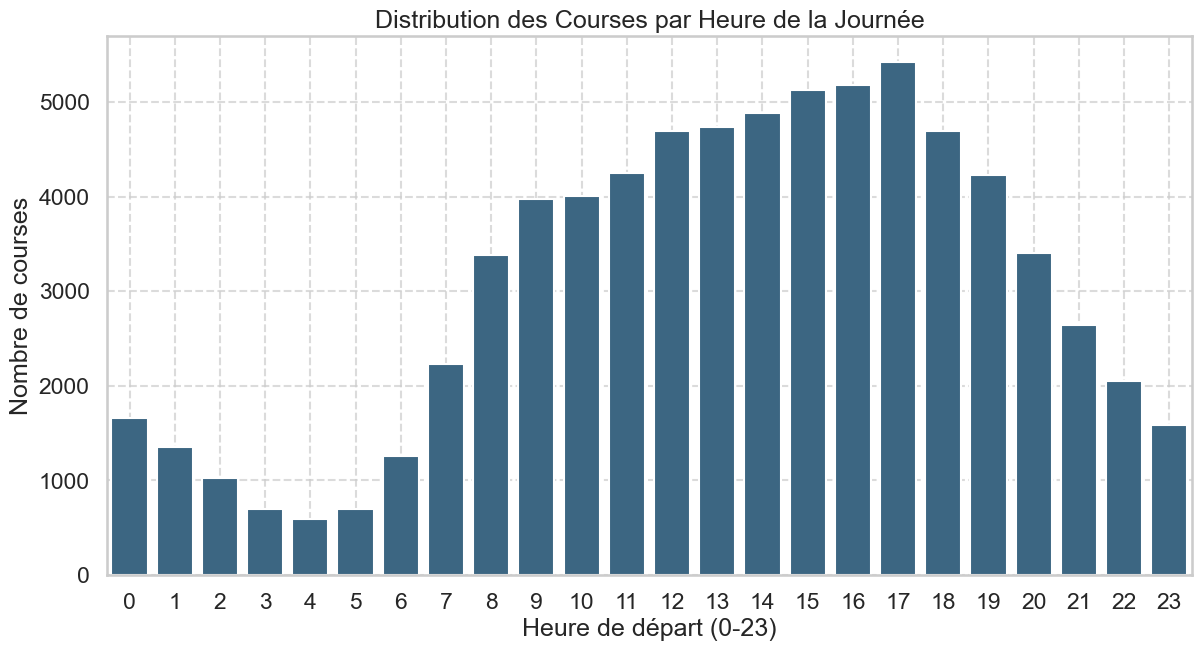

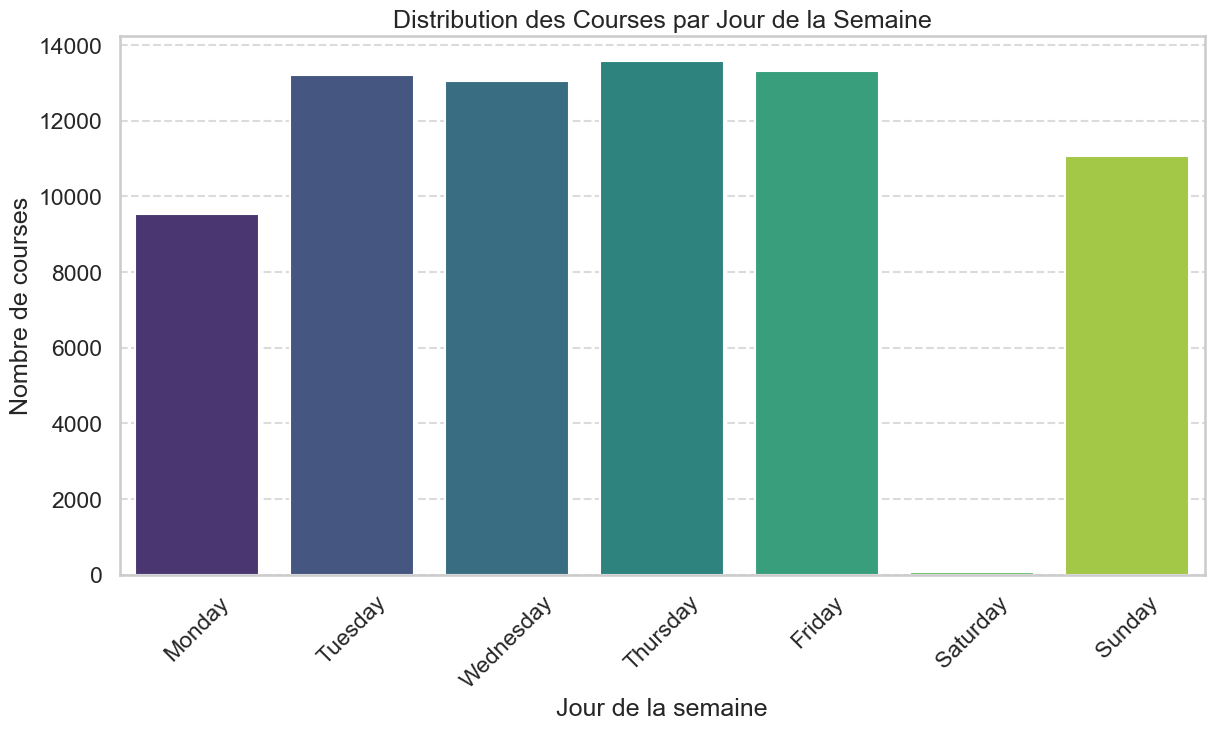

In [7]:
# Création de features temporelles
if 'trip_start_timestamp' in df_sample.columns:
    print("\n⏳ Création des features temporelles à partir de 'trip_start_timestamp'...")
    df_sample['start_hour'] = df_sample['trip_start_timestamp'].dt.hour
    df_sample['day_of_week'] = df_sample['trip_start_timestamp'].dt.dayofweek  # 0=Lundi, 6=Dimanche
    df_sample['day_name'] = df_sample['trip_start_timestamp'].dt.day_name()  # Nom du jour
    df_sample['month'] = df_sample['trip_start_timestamp'].dt.month
    df_sample['is_weekend'] = df_sample['day_of_week'].isin([5, 6]).astype(int)  # 1 si weekend, 0 sinon
    
    # Visualisation des tendances par heure
    plt.figure(figsize=(14, 7))
    hourly_count = df_sample.groupby('start_hour').size()
    sns.barplot(x=hourly_count.index, y=hourly_count.values, color=base_palette[2])
    plt.title("Distribution des Courses par Heure de la Journée")
    plt.xlabel("Heure de départ (0-23)")
    plt.ylabel("Nombre de courses")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # Visualisation des tendances par jour de la semaine
    plt.figure(figsize=(14, 7))
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    sns.countplot(data=df_sample, x='day_name', order=day_order, palette=sns.color_palette("viridis", 7))
    plt.title("Distribution des Courses par Jour de la Semaine")
    plt.xlabel("Jour de la semaine")
    plt.ylabel("Nombre de courses")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.show()

count    72299.000000
mean        24.374425
std        390.424836
min          0.000000
25%          9.000000
50%         15.000000
75%         29.030979
max      65808.000000
Name: average_speed_mph, dtype: float64


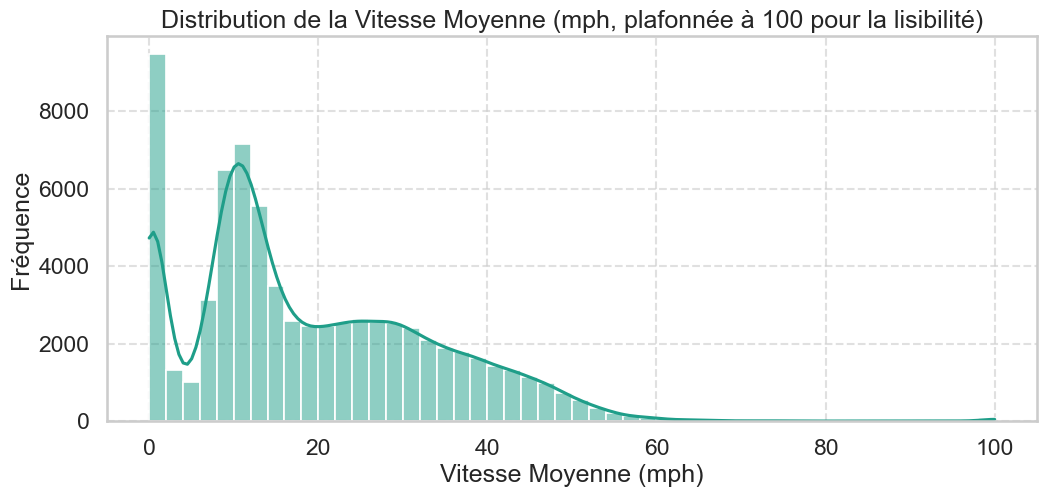

In [8]:
# Calcul de la vitesse moyenne en miles par heure
if 'trip_miles' in df_sample.columns and 'trip_minutes' in df_sample.columns:
    print(df_sample['average_speed_mph'].describe())

    # Visualisation de la distribution
    plt.figure(figsize=(12, 5))
    sns.histplot(df_sample['average_speed_mph'].clip(upper=100), bins=50, kde=True, color=base_palette[4])
    plt.title("Distribution de la Vitesse Moyenne (mph, plafonnée à 100 pour la lisibilité)")
    plt.xlabel("Vitesse Moyenne (mph)")
    plt.ylabel("Fréquence")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("⚠️ Colonnes 'trip_miles' ou 'trip_minutes' manquantes, impossible de calculer la vitesse moyenne.")

Nous représentons la vitesse médiane par heure, car elle est moins sensible aux vitesses extrêmes par rapport à la moyenne.


📈 Calcul de la vitesse moyenne médiane par heure de début...


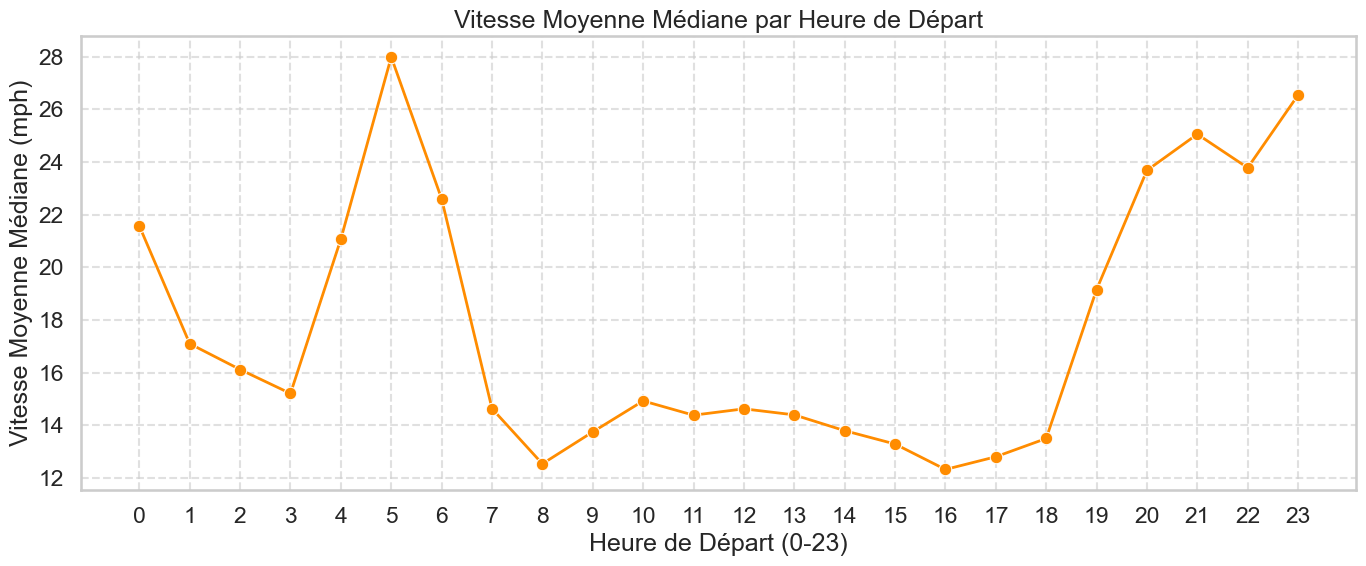

In [9]:
# Analyse temporelle : vitesse moyenne médiane par heure de départ
if 'average_speed_mph' in df_sample.columns and 'start_hour' in df_sample.columns:
    print("\n📈 Calcul de la vitesse moyenne médiane par heure de début...")

    avg_speed_by_hour = df_sample.groupby('start_hour')['average_speed_mph'].median().reset_index()

    plt.figure(figsize=(14, 6))
    sns.lineplot(data=avg_speed_by_hour, x='start_hour', y='average_speed_mph', marker='o',
                 linewidth=2, color='darkorange')
    plt.title("Vitesse Moyenne Médiane par Heure de Départ")
    plt.xlabel("Heure de Départ (0-23)")
    plt.ylabel("Vitesse Moyenne Médiane (mph)")
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Colonnes 'average_speed_mph' ou 'start_hour' manquantes.")

## 2.5 Analyse Spatiale

Examinons la distribution des courses par zone communautaire. Les cartes de chaleur utilisent un échantillon de 10 000 points pour équilibrer le détail visuel avec les performances de rendu.

In [10]:
import folium
from folium.plugins import HeatMap

# Centrer la carte sur Chicago
map_center = [41.8781, -87.6298]  # Coordonnées de Chicago
base_map = folium.Map(location=map_center, zoom_start=11)

# Option de filtrage pour éviter surcharge (ex: 10k points)
sampled_pickups = df_sample[['pickup_latitude', 'pickup_longitude']].dropna().sample(n=10000, random_state=42)

# Conversion au format liste de points
heat_data = sampled_pickups.values.tolist()

# Ajout du HeatMap
HeatMap(heat_data, radius=8, blur=10, max_zoom=12).add_to(base_map)

# Affichage
print("🌡️ Carte thermique des points de prise en charge (pickup)")
display(base_map)

🌡️ Carte thermique des points de prise en charge (pickup)


In [11]:
# Carte centrée sur Chicago
dropoff_map = folium.Map(location=map_center, zoom_start=11)

# Filtrage dropoff (évite surcharge sur grand jeu)
sampled_dropoffs = df_sample[['dropoff_latitude', 'dropoff_longitude']].dropna().sample(n=10000, random_state=42)

# Conversion en liste de points
heat_data_dropoff = sampled_dropoffs.values.tolist()

# Ajout du HeatMap
HeatMap(heat_data_dropoff, radius=8, blur=10, max_zoom=12).add_to(dropoff_map)

# Affichage
print("🌡️ Carte thermique des points de dépose (dropoff)")
display(dropoff_map)

🌡️ Carte thermique des points de dépose (dropoff)


## 2.6 Investigation des Outliers
Comme exemple de traitement des valeurs aberrantes, nous pouvons appliquer un clipping IQR aux caractéristiques numériques comme trip_miles. Cela aide à visualiser la distribution de la majorité des données, en excluant les valeurs extrêmes. La colonne trip_miles_iqr_capped générée ici est utilisée à des fins exploratoires mais n'est pas actuellement utilisée dans la préparation finale du dataset de forecasting dans la Section 3.

In [12]:
# Fonction de clipping IQR
def iqr_clip(series, verbose=True):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(0, Q1 - 1.5 * IQR)
    upper_bound = Q3 + 1.5 * IQR
    clipped = series.clip(lower=lower_bound, upper=upper_bound)
    if verbose:
        print(f"IQR Clipping → {series.name}: [{lower_bound:.2f}, {upper_bound:.2f}]")
    return clipped

# Clipping IQR sur la distance
if 'trip_miles' in df_sample.columns:
    df_sample['trip_miles_iqr_capped'] = iqr_clip(df_sample['trip_miles'].dropna(), verbose=True)
    print("✅ Colonne 'trip_miles_iqr_capped' créée.")
else:
    print("❌ Colonne 'trip_miles' non trouvée, impossible de créer 'trip_miles_iqr_capped'.")

IQR Clipping → trip_miles: [0.00, 27.05]
✅ Colonne 'trip_miles_iqr_capped' créée.


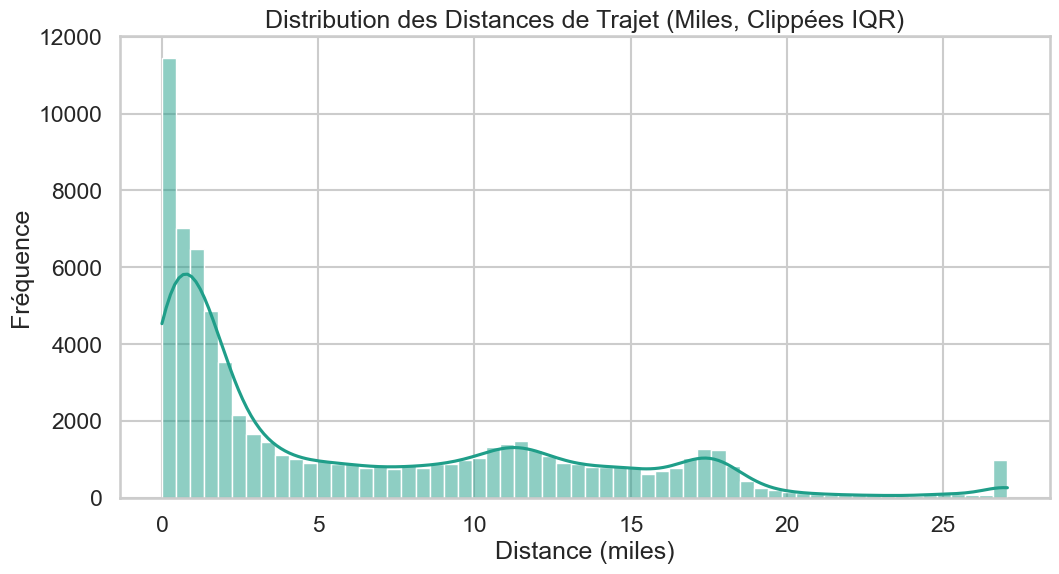

In [13]:
plt.figure(figsize=(12, 6))
if 'trip_miles_iqr_capped' in df_sample.columns:
    sns.histplot(df_sample['trip_miles_iqr_capped'], bins=60, kde=True, color=base_palette[4])
    plt.title("Distribution des Distances de Trajet (Miles, Clippées IQR)")
    plt.xlabel("Distance (miles)")
    plt.ylabel("Fréquence")
else:
    print("Colonne 'trip_miles_iqr_capped' non disponible.")
plt.show()

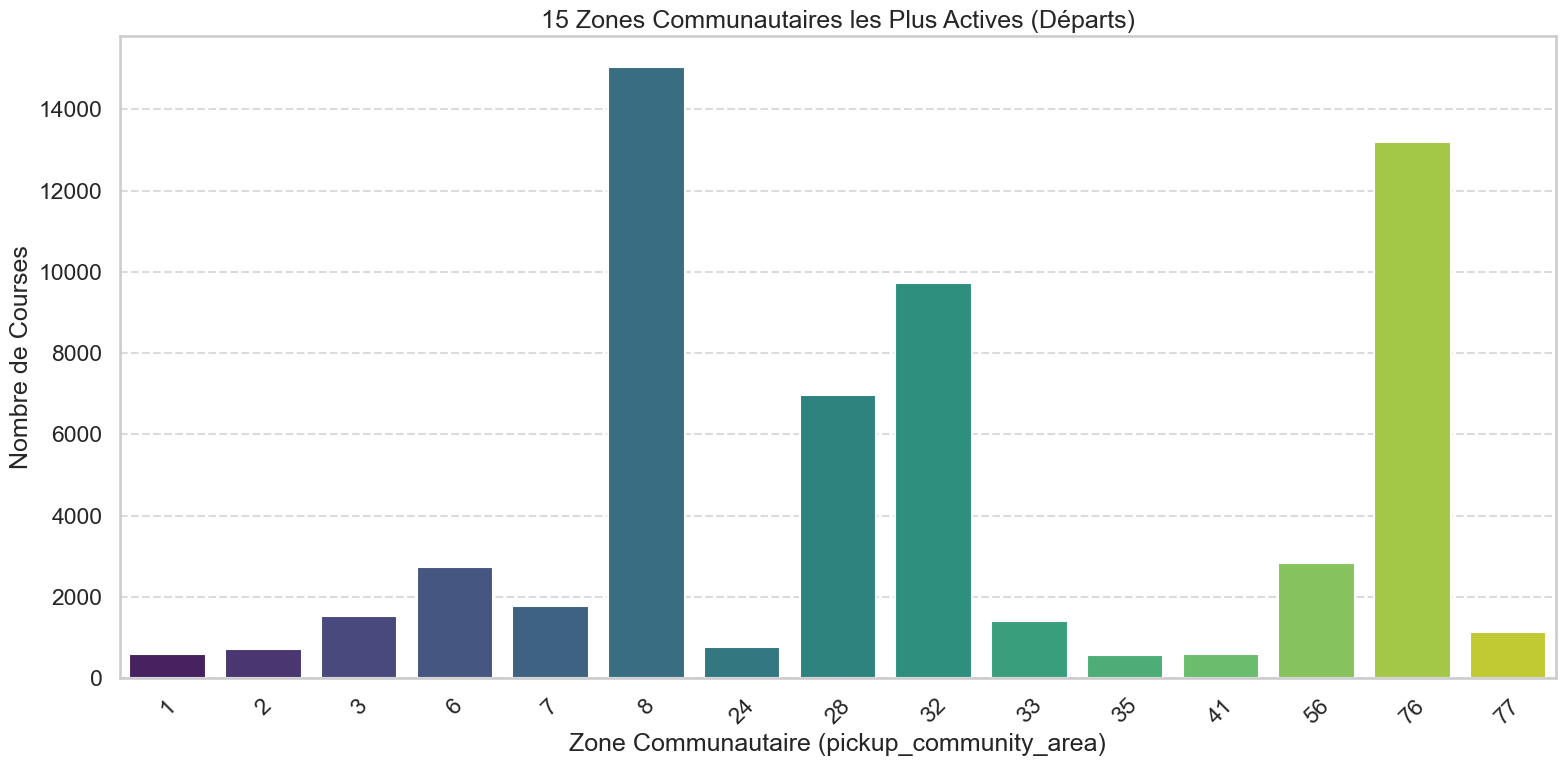

In [14]:
# Analyse des zones communautaires (pickup_community_area)
if 'pickup_community_area' in df_sample.columns:
    # Compter les courses par zone
    zone_counts = df_sample['pickup_community_area'].value_counts().reset_index()
    zone_counts.columns = ['pickup_community_area', 'count']
    zone_counts = zone_counts.sort_values('count', ascending=False)
    
    # Afficher les 15 principales zones
    plt.figure(figsize=(16, 8))
    sns.barplot(data=zone_counts.head(15), x='pickup_community_area', y='count', palette="viridis")
    plt.title("15 Zones Communautaires les Plus Actives (Départs)")
    plt.xlabel("Zone Communautaire (pickup_community_area)")
    plt.ylabel("Nombre de Courses")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()

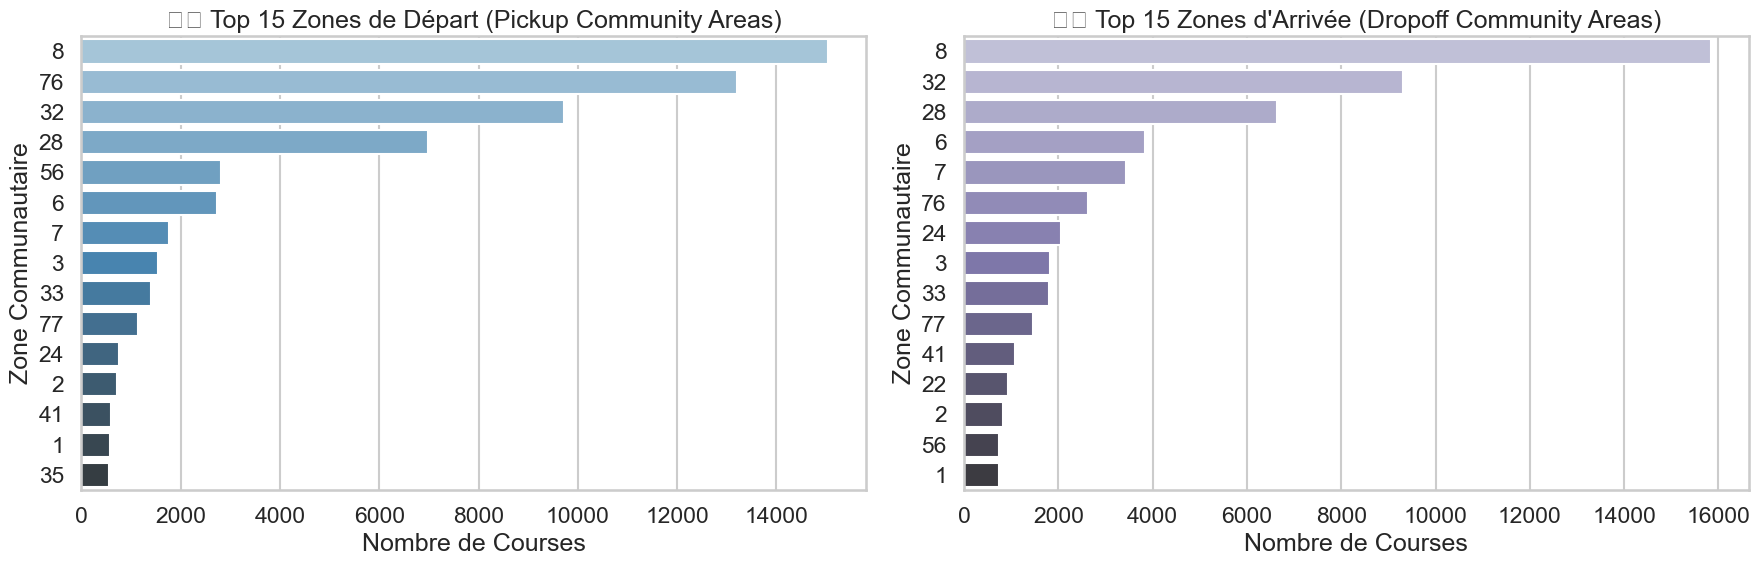

In [15]:
# Vérification existence colonnes
if 'pickup_community_area' in df_sample.columns and 'dropoff_community_area' in df_sample.columns:
    # Top zones départ
    pickup_area_counts = df_sample['pickup_community_area'].value_counts().sort_values(ascending=False).head(15)
    dropoff_area_counts = df_sample['dropoff_community_area'].value_counts().sort_values(ascending=False).head(15)

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Pickups
    sns.barplot(y=pickup_area_counts.index.astype(str),
                x=pickup_area_counts.values,
                ax=axes[0],
                palette="Blues_d")
    axes[0].set_title("🏙️ Top 15 Zones de Départ (Pickup Community Areas)")
    axes[0].set_xlabel("Nombre de Courses")
    axes[0].set_ylabel("Zone Communautaire")

    # Dropoffs
    sns.barplot(y=dropoff_area_counts.index.astype(str),
                x=dropoff_area_counts.values,
                ax=axes[1],
                palette="Purples_d")
    axes[1].set_title("🏙️ Top 15 Zones d'Arrivée (Dropoff Community Areas)")
    axes[1].set_xlabel("Nombre de Courses")
    axes[1].set_ylabel("Zone Communautaire")

    plt.tight_layout()
    plt.show()
else:
    print("Les colonnes 'pickup_community_area' ou 'dropoff_community_area' sont absentes du DataFrame.")

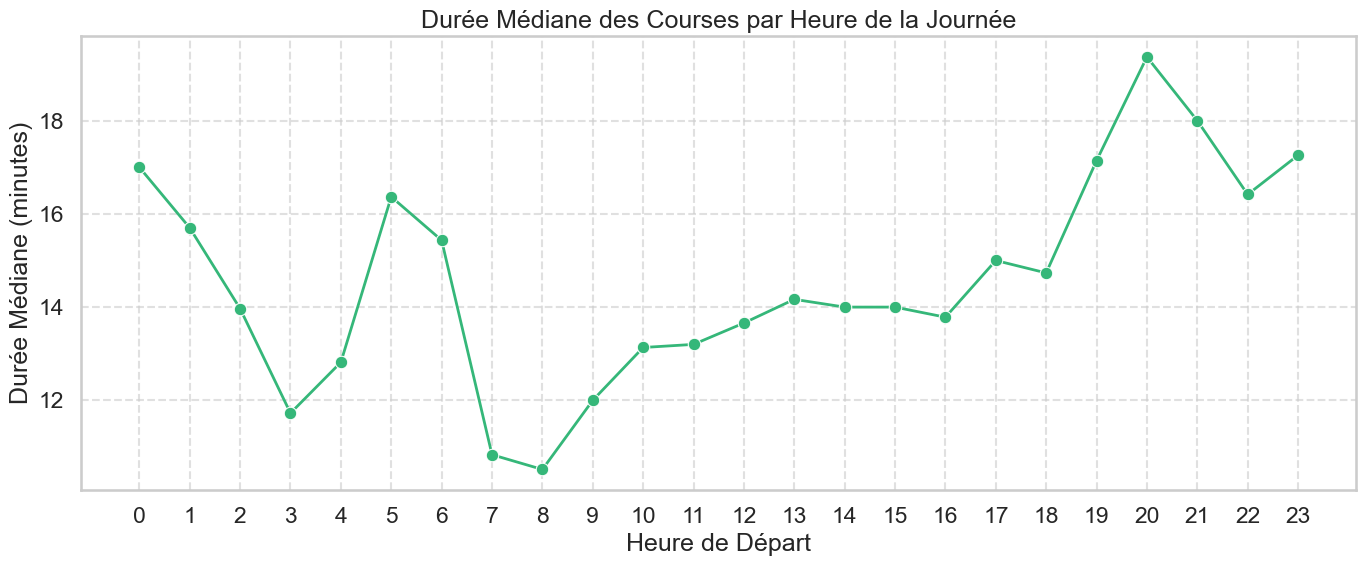

In [16]:
if 'start_hour' in df_sample.columns and 'trip_minutes' in df_sample.columns:
    # Durée médiane par heure
    duration_by_hour = df_sample.groupby('start_hour')['trip_minutes'].median().reset_index()

    plt.figure(figsize=(14, 6))
    sns.lineplot(data=duration_by_hour, x='start_hour', y='trip_minutes',
                 marker='o', linewidth=2, color=base_palette[5])
    plt.title("Durée Médiane des Courses par Heure de la Journée")
    plt.xlabel("Heure de Départ")
    plt.ylabel("Durée Médiane (minutes)")
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Colonnes 'start_hour' ou 'trip_minutes' non disponibles.")

# 3. Préparation des Données pour le Forecasting

Maintenant que nous avons exploré les données, préparons-les pour le forecasting en les agrégeant par heure et par zone.

 ## 3.0 Définition de la Plage Temporelle pour l'Export
Conformément aux exigences de Vertex AI Forecast (limite d'environ 3000 points ar série), nous allons calculer la plage de dates à exporter. Nous utilisons les paramètres du fichier de configuration.

In [ ]:
from datetime import datetime, timedelta

# Charger la configuration si ce n'est pas déjà fait plus haut
if 'config' not in locals():
    try:
        with open("../config/pipeline_config.yaml", "r") as f:
            config = yaml.safe_load(f)
        print("Configuration chargée.")
    except FileNotFoundError:
         with open("config/pipeline_config.yaml", "r") as f:
            config = yaml.safe_load(f)
         print("Configuration chargée.")
    except Exception as e:
        print(f"Erreur chargement config: {e}. Utilisation de valeurs par défaut.")
        config = {
            "forecasting": {
                "time_column": "timestamp_hour",
                "target_column": "trip_count",
                "context_column": "pickup_community_area",
                "forecast_horizon": 24,
                "window_size": 168,
                "available_at_forecast": [
                    "timestamp_hour", "day_of_year", "day_of_week", "hour", 
                    "month", "is_weekend"
                ],
                "unavailable_at_forecast": ["trip_count"],
                "data_granularity_unit": "hour"
            },
            "vertex_ai_forecast": {
                "display_name": "chicago_taxi_forecast_model",
                "optimization_objective": "minimize-rmse",
                "budget_milli_node_hours": 100
            }
        }
else:
    # S'il existe déjà une variable 'config' dans l'espace local
    print("La configuration est déjà chargée.")
        
# Récupérer les paramètres de la fenêtre temporelle depuis le config

forecast_config = config.get('forecasting', {})
time_window_config = forecast_config.get('time_window', {})

DEFAULT_END_DATE = "2023-11-22" # Valeur par défaut si non configurée
DEFAULT_MAX_POINTS = 2950      # Valeur par défaut (marge sous 3000)

end_date_str = time_window_config.get('end_date', DEFAULT_END_DATE)
max_data_points = time_window_config.get('max_data_points', DEFAULT_MAX_POINTS)

# Calculer la date de début
try:
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    # Calculer la date de début pour avoir au maximum 'max_data_points' heures
    # Ajouter 1 heure car la plage est inclusive au début et exclusive à la fin dans certaines fonctions
    start_date = end_date - timedelta(hours=max_data_points - 1)
    start_date_str = start_date.strftime("%Y-%m-%d")

except ValueError:
    print(f"⚠️ Format de date incorrect dans config ('{end_date_str}'). Utilisation de la date par défaut.")
    end_date_str = DEFAULT_END_DATE
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    start_date = end_date - timedelta(hours=max_data_points - 1)
    start_date_str = start_date.strftime("%Y-%m-%d")

# Calcul du nombre d'heures approximatif dans la plage
hours_diff = int((end_date - start_date).total_seconds() // 3600)


# Vérification de la limite de Vertex AI (3000 points par série)
if hours_diff > 3000:
    print(f"⚠️ ATTENTION: Le nombre d'heures ({hours_diff}) dépasse la limite de 3000 points de Vertex AI.")
    print("La période va être automatiquement ajustée pour respecter cette limite.")
    
    # Ajuster la date de début pour rester sous ~3000 heures
    adjusted_start = end_date - timedelta(hours=2950)  # Marge de sécurité
    start_date_str = adjusted_start.strftime("%Y-%m-%d")
    hours_diff = 2950
    print(f"📅 Nouvelle plage ajustée: {start_date_str} à {end_date_str} (~{hours_diff} heures)")
else:
    print(f"✅ La plage respecte la limite de Vertex AI (max 3000 points par série): {hours_diff} heures.")

# Définir les timestamps complets pour le filtrage (SQL, Pandas, etc.)
# On inclut tout le jour de début (00:00:00) et tout le jour de fin (23:59:59)
start_timestamp_str = f"{start_date_str} 00:00:00"
end_timestamp_str   = f"{end_date_str} 23:59:59"

print("=== Récapitulatif final ===")
print(f"  Start Timestamp   : {start_timestamp_str}")
print(f"  End Timestamp     : {end_timestamp_str}\n")
print(f"Nombre d'heures dans la plage : {hours_diff} heures")

La configuration est déjà chargée.
✅ La plage respecte la limite de Vertex AI (max 3000 points par série): 2949 heures.
=== Récapitulatif final ===
  Start Timestamp   : 2023-07-22 00:00:00
  End Timestamp     : 2023-11-22 23:59:59

Nombre d'heures dans la plage : 2949 heures


## 3.1 Extraction des Données Complètes pour le Forecasting

Chargeons les données complètes avec les colonnes essentielles pour le forecasting. Nous chargerons les données du 1er janvier 2022 au 31 décembre 2022 (inclus). L'utilisation d'une année récente complète aide à capturer la saisonnalité et fournit suffisamment de données pour entraîner le modèle Vertex AI Forecast.

In [18]:
# Requête SQL pour charger les données nécessaires au forecasting
forecasting_query = f"""
SELECT
  trip_start_timestamp,
  pickup_community_area
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE 
  pickup_community_area IS NOT NULL
  AND trip_start_timestamp >= '{start_timestamp_str}'
  AND trip_start_timestamp < '{end_timestamp_str}'
"""

print("Chargement des données depuis BigQuery... (peut prendre plusieurs minutes)")

# Option 1 : Charger via python - peut être lent pour de grands volumes
try:
    df_raw = read_gbq(forecasting_query, project_id=PROJECT_ID)
    print(f"✅ Dataset chargé avec succès. Nombre de lignes : {len(df_raw):,}")
except Exception as e:
    print(f"Erreur lors du chargement depuis BigQuery: {e}")
    print("⚠️ Nous allons passer à l'option 2: agrégation directe dans BigQuery")
    df_raw = None

# Option 2 (alternative) : Effectuer l'agrégation directement dans BigQuery
# Cette option est commentée car elle nécessite des privilèges d'écriture dans BigQuery
# Elle sera utilisée plus tard si nécessaire

Chargement des données depuis BigQuery... (peut prendre plusieurs minutes)
Downloading: 100%|██████████|
✅ Dataset chargé avec succès. Nombre de lignes : 2,219,873


## 3.2 Agrégation Temporelle par Heure et Zone

Agrégeons les données par heure et par zone communautaire pour créer la série temporelle.

In [19]:
if df_raw is not None:
    # Convertir les timestamps au format horaire (arrondi à l'heure)
    df_raw["timestamp_hour"] = pd.to_datetime(df_raw["trip_start_timestamp"]).dt.floor("H")
    
    # Agrégation : nombre de courses par heure et par pickup_community_area
    df_demand = (
        df_raw
        .groupby(["timestamp_hour", "pickup_community_area"])
        .size()
        .reset_index(name="trip_count")
        .sort_values(["timestamp_hour", "pickup_community_area"])
    )
    
    print(f"✅ Données agrégées : {len(df_demand):,} lignes.")
    df_demand.head()
else:
    print("⚠️ Pas de données brutes disponibles pour l'agrégation.")

✅ Données agrégées : 131,762 lignes.


## 3.3 Complétion des Séries Temporelles

Assurons-nous que toutes les combinaisons d'heures et de zones existent, même s'il n'y a pas de courses. Les modèles de forecasting, en particulier ceux utilisés par Vertex AI Forecast, nécessitent une série temporelle complète pour chaque élément (zone communautaire). Nous créons tous les timestamps horaires possibles dans la plage de données et les joignons avec toutes les zones communautaires uniques. Nous fusionnons ensuite les décomptes réels, en remplissant toute combinaison heure/zone manquante (où aucune course n'a eu lieu) avec la valeur 0.

In [20]:
if 'df_demand' in locals() and not df_demand.empty:
    # Créer l'ensemble des heures disponibles dans le dataset (par pas de 1 heure)
    min_time = df_demand["timestamp_hour"].min()
    max_time = df_demand["timestamp_hour"].max()
    all_hours = pd.date_range(start=min_time, end=max_time, freq="H")
    
    # Identifier toutes les zones uniques
    all_zones = df_demand["pickup_community_area"].dropna().unique()
    all_zones = sorted(all_zones)
    
    # Créer le produit cartésien : toutes les combinaisons heure × zone
    complete_index = pd.MultiIndex.from_product(
        [all_hours, all_zones],
        names=["timestamp_hour", "pickup_community_area"]
    )
    
    # Créer un DataFrame complet
    df_complete = pd.DataFrame(index=complete_index).reset_index()
    
    # Fusionner avec les données observées
    df_demand_complete = pd.merge(
        df_complete,
        df_demand,
        on=["timestamp_hour", "pickup_community_area"],
        how="left"
    )
    
    # Remplacer les valeurs manquantes (heures sans courses) par 0
    df_demand_complete["trip_count"] = df_demand_complete["trip_count"].fillna(0).astype(int)
    
    print(f"✅ Séries temporelles complétées : {len(df_demand_complete):,} lignes.")
    df_demand_complete.head()
else:
    print("⚠️ Pas de données agrégées disponibles pour la complétion des séries temporelles.")

✅ Séries temporelles complétées : 229,152 lignes.


## 3.4 Ingénierie de Features Temporelles

Ajoutons des features temporelles utiles pour le forecasting. Nous extrayons des caractéristiques temporelles standard. De plus, nous créons des features cycliques pour l'heure (hour_sin, hour_cos). Cela aide les modèles à comprendre la nature cyclique du temps, par exemple que l'heure 23 est proche de l'heure 0.

In [21]:
if 'df_demand_complete' in locals() and not df_demand_complete.empty:
    # Extraire les features temporelles classiques
    df_demand_complete["hour"] = df_demand_complete["timestamp_hour"].dt.hour
    df_demand_complete["day_of_week"] = df_demand_complete["timestamp_hour"].dt.dayofweek  # Lundi = 0
    df_demand_complete["month"] = df_demand_complete["timestamp_hour"].dt.month
    df_demand_complete["day_of_year"] = df_demand_complete["timestamp_hour"].dt.dayofyear
    df_demand_complete["week_of_year"] = df_demand_complete["timestamp_hour"].dt.isocalendar().week.astype(int)
    df_demand_complete["year"] = df_demand_complete["timestamp_hour"].dt.year
    df_demand_complete["is_weekend"] = df_demand_complete["day_of_week"].isin([5, 6]).astype(int)
    
    # Encodage cyclique pour l'heure (utile pour certains modèles)
    df_demand_complete["hour_sin"] = np.sin(2 * np.pi * df_demand_complete["hour"] / 24)
    df_demand_complete["hour_cos"] = np.cos(2 * np.pi * df_demand_complete["hour"] / 24)
    
    print("✅ Features temporelles ajoutées.")
    # Aperçu
    df_demand_complete[["timestamp_hour", "pickup_community_area", "trip_count", "hour", "day_of_week", "month", "is_weekend"]].head()
else:
    print("⚠️ Pas de données disponibles pour l'ajout de features temporelles.")

✅ Features temporelles ajoutées.


## 3.5 Visualisation des Séries Temporelles

Visualisons les séries temporelles pour quelques zones principales. Pour visualiser les tendances globales, nous agrégeons d'abord les comptages horaires au niveau journalier pour les 5 zones les plus fréquentées. Cela lisse les fluctuations horaires.

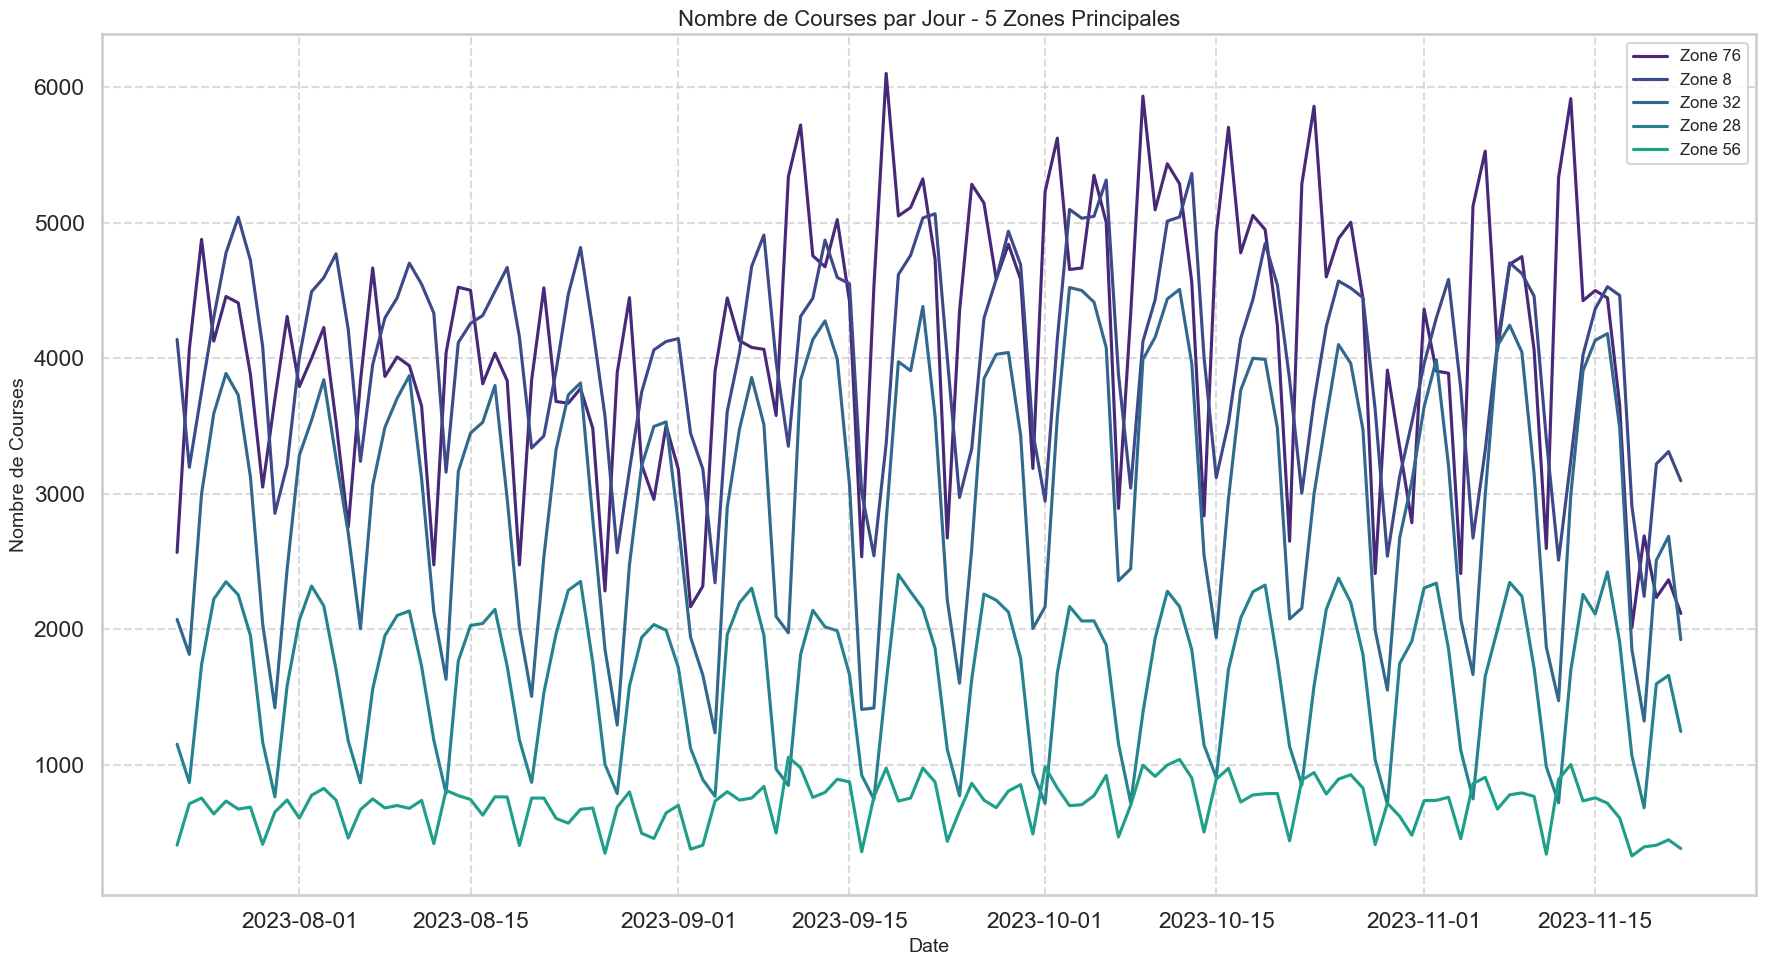

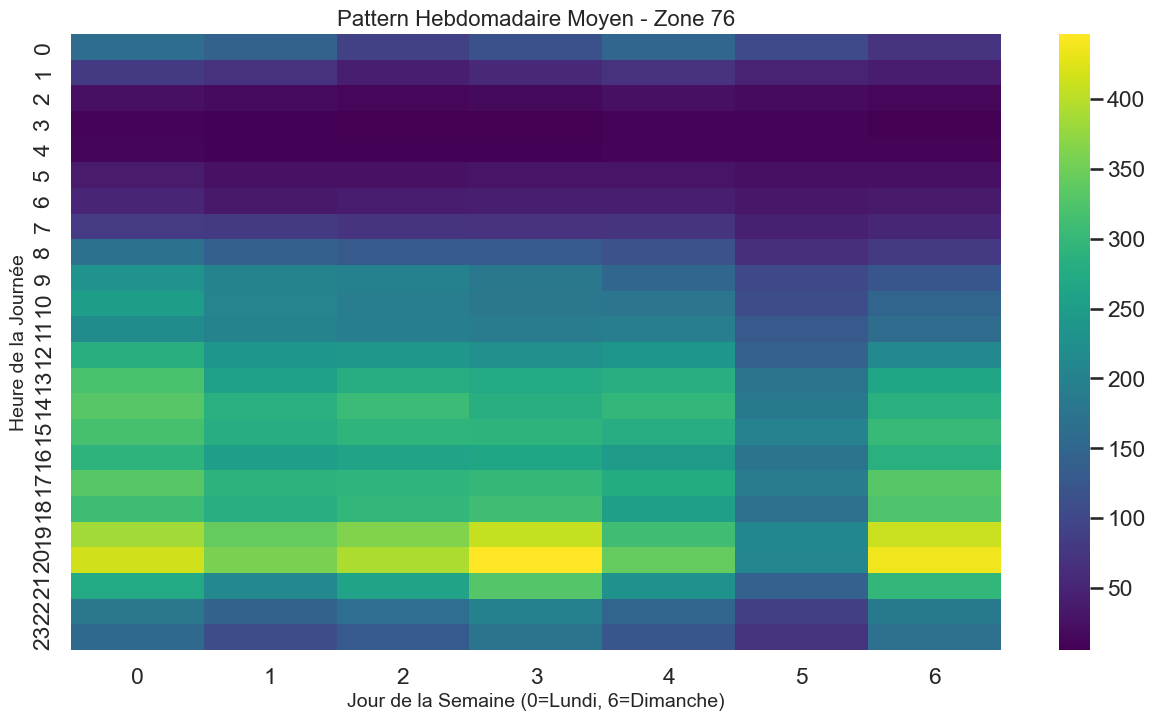

In [22]:
if 'df_demand_complete' in locals() and not df_demand_complete.empty:
    # Identifier les zones les plus actives
    top_active_zones = df_demand_complete.groupby('pickup_community_area')['trip_count'].sum().nlargest(5).index.tolist()
    
    # Filtrer pour ces zones
    df_top_zones = df_demand_complete[df_demand_complete['pickup_community_area'].isin(top_active_zones)]
    
    # Agréger par jour pour simplifier la visualisation
    df_top_zones['date'] = df_top_zones['timestamp_hour'].dt.date
    df_daily = df_top_zones.groupby(['date', 'pickup_community_area'])['trip_count'].sum().reset_index()
    
    # Visualiser les tendances pour les 5 zones principales
    plt.figure(figsize=(18, 10))
    for zone in top_active_zones:
        df_zone = df_daily[df_daily['pickup_community_area'] == zone]
        plt.plot(df_zone['date'], df_zone['trip_count'], label=f'Zone {zone}')
    
    plt.title('Nombre de Courses par Jour - 5 Zones Principales', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Nombre de Courses', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Visualisation hebdomadaire pour une zone spécifique
    # Sélectionner la zone la plus active
    top_zone = top_active_zones[0]
    
    # Analyse par jour de la semaine
    df_top_zone = df_demand_complete[df_demand_complete['pickup_community_area'] == top_zone]
    weekly_pattern = df_top_zone.groupby(['day_of_week', 'hour'])['trip_count'].mean().reset_index()
    weekly_pattern_pivot = weekly_pattern.pivot(index='hour', columns='day_of_week', values='trip_count')
    
    # Visualisation heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(weekly_pattern_pivot, cmap="viridis", annot=False, fmt=".1f")
    plt.title(f'Pattern Hebdomadaire Moyen - Zone {top_zone}', fontsize=16)
    plt.xlabel('Jour de la Semaine (0=Lundi, 6=Dimanche)', fontsize=14)
    plt.ylabel('Heure de la Journée', fontsize=14)
    plt.show()
else:
    print("⚠️ Pas de données disponibles pour la visualisation des séries temporelles.")

## 3.6 Export vers BigQuery pour Vertex AI Forecast

Exportons les données préparées vers BigQuery pour l'utilisation avec Vertex AI Forecast. Le schéma final de la table comprend le timestamp, l'identifiant (pickup_community_area), la cible (trip_count) et les features temporelles générées. La requête SQL tente de créer directement la table filtrée.
Si cela échoue (ex: droits), nous filtrons le DataFrame Pandas
`df_demand_complete` et l'exportons.

In [23]:
if 'df_demand_complete' in locals() and not df_demand_complete.empty:
    BQ_TABLE_ID = f"{PROJECT_ID}.{BQ_DATASET}.demand_by_hour"
    export_success = False
    print(f"Début de l'export vers : {BQ_TABLE_ID}")
    print(f"Utilisation de la plage horaire: {start_timestamp_str} à {end_timestamp_str}")

    # --- Méthode 1: Requête SQL Directe (Préférée) ---
    # Cette requête effectue l'agrégation, la complétion, l'ajout de features
    # ET le filtrage temporel en une seule fois.

    bq_query = f"""
    CREATE OR REPLACE TABLE `{BQ_TABLE_ID}` AS
    WITH
      raw_trips AS (
        SELECT trip_start_timestamp, pickup_community_area
        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE
          pickup_community_area IS NOT NULL
          -- Filtrage temporel appliqué ici sur les données brutes
          AND trip_start_timestamp >= TIMESTAMP("{start_timestamp_str}")
          AND trip_start_timestamp <= TIMESTAMP("{end_timestamp_str}")
      ),
      hours AS (
        -- Générer toutes les heures dans la plage filtrée
        SELECT timestamp_hour
        FROM UNNEST(GENERATE_TIMESTAMP_ARRAY(
                TIMESTAMP("{start_timestamp_str}"),
                TIMESTAMP("{end_timestamp_str}"),
                INTERVAL 1 HOUR)) AS timestamp_hour
      ),
      areas AS (
        -- Obtenir les zones uniques des données DÉJÀ filtrées
        SELECT DISTINCT pickup_community_area
        FROM raw_trips
      ),
      all_combinations AS (
        -- Créer la grille complète pour la période et les zones concernées
        SELECT
          h.timestamp_hour,
          a.pickup_community_area
        FROM hours h
        CROSS JOIN areas a
      ),
      aggregated AS (
        -- Agréger les courses par heure et zone DANS la période filtrée
        SELECT
          TIMESTAMP_TRUNC(trip_start_timestamp, HOUR) AS timestamp_hour,
          pickup_community_area,
          COUNT(*) AS trip_count
        FROM raw_trips -- Utiliser les données déjà filtrées
        GROUP BY 1, 2
      ),
      filled AS (
        -- Joindre la grille complète avec les agrégats et remplir les vides avec 0
        SELECT
          ac.timestamp_hour,
          ac.pickup_community_area,
          IFNULL(agg.trip_count, 0) AS trip_count
        FROM all_combinations ac
        LEFT JOIN aggregated agg
          ON ac.timestamp_hour = agg.timestamp_hour
         AND ac.pickup_community_area = agg.pickup_community_area
      )
    -- Sélection finale avec toutes les features temporelles
    SELECT
      timestamp_hour,
      pickup_community_area,
      trip_count,
      EXTRACT(HOUR FROM timestamp_hour) AS hour,
      EXTRACT(DAYOFWEEK FROM timestamp_hour) AS day_of_week, -- Dimanche=1 à Samedi=7 en BQ, mais Vertex AI gère
      EXTRACT(MONTH FROM timestamp_hour) AS month,
      EXTRACT(YEAR FROM timestamp_hour) AS year,
      EXTRACT(DAYOFYEAR FROM timestamp_hour) AS day_of_year,
      CAST(EXTRACT(ISOWEEK FROM timestamp_hour) AS INT64) as week_of_year, # Ajouté si besoin
      IF(EXTRACT(DAYOFWEEK FROM timestamp_hour) IN (1, 7), 1, 0) AS is_weekend,
      -- Ajout des features cycliques
      SIN(2 * ACOS(-1) * EXTRACT(HOUR FROM timestamp_hour) / 24) AS hour_sin,
      COS(2 * ACOS(-1) * EXTRACT(HOUR FROM timestamp_hour) / 24) AS hour_cos
    FROM filled
    ORDER BY timestamp_hour, pickup_community_area;
    """
    
    # Exécuter la requête BigQuery
    print("Exécution de la requête d'agrégation directement dans BigQuery...")
    try:
        # S'assurer que le client BigQuery est initialisé
        if 'client' not in locals():
             client = bigquery.Client(project=PROJECT_ID)

        job = client.query(bq_query)
        job.result()  # Attendre la fin du job
        print(f"✅ Table exportée vers BigQuery : {BQ_TABLE_ID}")
        export_success = True

        # Afficher un extrait des données exportées
        print("\nExtrait des données dans la table BigQuery créée :")
        preview_query = f"SELECT * FROM `{BQ_TABLE_ID}` ORDER BY timestamp_hour, pickup_community_area LIMIT 5"
        df_preview = client.query(preview_query).to_dataframe()
        display(df_preview)

    except Exception as e:
        print(f"⚠️ Erreur lors de l'exécution de la requête BigQuery : {e}")
        print("Passage à la méthode 2 (Export depuis Pandas DataFrame).")
        export_success = False # Réinitialiser au cas où


    # --- Méthode 2: Export depuis Pandas DataFrame (Fallback) ---

    if not export_success:
      # Option alternative: exporter depuis pandas si la requête SQL échoue
      try:
          print("\nTentative d'export via pandas DataFrame (Méthode 2)...")
          # S'assurer que le DataFrame existe et n'est pas vide
          if "df_demand_complete" in locals() and df_demand_complete is not None and not df_demand_complete.empty:
            # --- FILTRAGE DU DATAFRAME PANDAS ---
            # Appliquer le même filtre temporel que la requête SQL
            print(f"Filtrage du DataFrame Pandas entre {start_timestamp_str} et {end_timestamp_str}...")
            df_filtered_pandas = df_demand_complete[
              (df_demand_complete['timestamp_hour'] >= pd.to_datetime(start_timestamp_str, utc=True)) &
              (df_demand_complete['timestamp_hour'] <= pd.to_datetime(end_timestamp_str, utc=True))
              ].copy() # Utiliser .copy() pour éviter SettingWithCopyWarning
            print(f"Nombre de lignes après filtrage Pandas: {len(df_filtered_pandas):,}")
            if not df_filtered_pandas.empty:
              # Sélectionner les colonnes pertinentes (celles générées précédemment ET dans la requête SQL)
              columns_to_keep = [
                  "timestamp_hour", "pickup_community_area", "trip_count",
                  "hour", "day_of_week", "month", "year", "day_of_year",
                  "week_of_year", # Assurez-vous qu'elle existe si utilisée
                  "is_weekend", "hour_sin", "hour_cos"
              ]
              # Garder uniquement les colonnes qui existent réellement dans le DataFrame
              columns_to_export = [col for col in columns_to_keep if col in df_filtered_pandas.columns]
              df_to_export = df_filtered_pandas[columns_to_export]

              # Configurer le job d'export
              job_config = bigquery.LoadJobConfig(
                  write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
                  # Détecter automatiquement le schéma ou le spécifier si nécessaire
                  autodetect=True,
              )

              # Exporter le DataFrame filtré
              job = client.load_table_from_dataframe(
                  df_to_export, BQ_TABLE_ID, job_config=job_config
              )
              job.result()  # Attendre la fin du job
              print(f"✅ Méthode 2: Table exportée vers BigQuery via pandas : {BQ_TABLE_ID}")
              export_success = True

              # Afficher un extrait
              print("\nExtrait des données exportées via Pandas:")
              display(df_to_export.head())
            else:
              print("⚠️ Le DataFrame est vide après filtrage, export annulé.")
          else:
            print("⚠️ DataFrame 'df_demand_complete' non trouvé ou vide. Export via Pandas impossible.")

      except Exception as e2:
          print(f"⚠️ Échec de l'export via pandas : {e2}")
else:
    # Si nous n'avons pas pu charger les données en mémoire, exécuter directement la requête
    print("Pas de données en mémoire, exécution de la requête d'agrégation directement dans BigQuery...")
    # (Code de la requête BigQuery identique à celui ci-dessus)
if not export_success:
  print(f"❌ Échec final de l'export vers BigQuery {BQ_TABLE_ID} par les deux méthodes.")

Début de l'export vers : avisia-certification-ml-yde.chicago_taxis.demand_by_hour
Utilisation de la plage horaire: 2023-07-22 00:00:00 à 2023-11-22 23:59:59
Exécution de la requête d'agrégation directement dans BigQuery...
⚠️ Erreur lors de l'exécution de la requête BigQuery : 404 Not found: Dataset avisia-certification-ml-yde:chicago_taxis was not found in location US; reason: notFound, message: Not found: Dataset avisia-certification-ml-yde:chicago_taxis was not found in location US

Location: US
Job ID: 4c7db964-512f-46ea-829c-5e0bbdb7061e

Passage à la méthode 2 (Export depuis Pandas DataFrame).

Tentative d'export via pandas DataFrame (Méthode 2)...
Filtrage du DataFrame Pandas entre 2023-07-22 00:00:00 et 2023-11-22 23:59:59...
Nombre de lignes après filtrage Pandas: 229,152
✅ Méthode 2: Table exportée vers BigQuery via pandas : avisia-certification-ml-yde.chicago_taxis.demand_by_hour

Extrait des données exportées via Pandas:


,timestamp_hour,pickup_community_area,trip_count,hour,day_of_week,month,year,day_of_year,week_of_year,is_weekend,hour_sin,hour_cos
0,2023-07-22 00:00:00+00:00,1,1,0,5,7,2023,203,29,1,0.0,1.0
1,2023-07-22 00:00:00+00:00,2,3,0,5,7,2023,203,29,1,0.0,1.0
2,2023-07-22 00:00:00+00:00,3,6,0,5,7,2023,203,29,1,0.0,1.0
3,2023-07-22 00:00:00+00:00,4,1,0,5,7,2023,203,29,1,0.0,1.0
4,2023-07-22 00:00:00+00:00,5,1,0,5,7,2023,203,29,1,0.0,1.0


# 4. Conclusion et Prochaines Étapes

## Résumé de l'Analyse
- Nous avons exploré le dataset Chicago Taxi Trips et identifié des patterns temporels importants.
- Les données ont été agrégées par heure et par zone communautaire (pickup_community_area).
- Nous avons créé des features temporelles utiles pour le forecasting.
- Les données préparées ont été exportées vers BigQuery pour une utilisation avec Vertex AI Forecast.

- **Principales Découvertes:**
    - Des patterns saisonniers horaires et hebdomadaires marqués ont été observés dans la demande de taxis.
    - La demande varie significativement selon les différentes zones communautaires de prise en charge, avec des zones comme les zones 76 et 8 présentant le volume le plus élevé.
    - Les vérifications de qualité des données ont révélé des problèmes comme des trajets de durée nulle, qui ont été traités pendant l'analyse et la préparation.

## Prochaines Étapes
- Utiliser Vertex AI Forecast pour entraîner un modèle de prévision (dans le notebook suivant).
- Évaluer la performance du modèle.
- Générer des prédictions pour les périodes futures.
- Visualiser les résultats de prévision pour aider à la prise de décision.